In [33]:
%load_ext watermark
%watermark -v -p pymc3,theano,pandas,numpy,mkl,arviz

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3 : 3.8
theano: 1.0.5
pandas: 1.1.4
numpy : 1.19.2
mkl   : 2019.0
arviz : 0.10.0



In [34]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

We will in this model do some simple supply chain modelling optimization. We'll use a stylised example that I've encountered in the past. 

My friend runs a small business and regularly purchases plastic. These suppliers have different prices, different quality items, and different maximum amounts they can ship us within a certain timeframe. We know the prices and order sizes, but the true yield distribution is unobserverable. Here, we include the unobservable parameters PLASTIC_SUPPLY_YIELD and PLASTIC_SUPPLY_YIELD_SD to simulate data, but we will assume we don't know them.

Examples of this in the real world. You may for example be purchasing plastic, and it needs to be a certain quality (or grade). You often won't know that in advance. But you may have prior data from the various suppliers. 

A plastic unit for us is 'per tonne'. And we'll restrict to one kind of plastic for this, a real world example may be more complicated.

In [35]:
PLASTIC_SUPPLIER_YIELD = np.array([.9, .5, .8, .6, .4]) # unknown
PLASTIC_SUPPLIER_YIELD_SD = np.array([.1, .2, .2, .1, 0.2]) # unknown
PRICES = [2200.0, 1000.0, 1200.0, 3000.00, 1200.0] # known
MAX_ORDER_SIZE = [100, 80, 100, 60, 490] # known

The yield represents the percentage of plastic that pass our quality tests (the consequences are fines if we don't do this we run the risk of being fined or even people looking for refunds). Due to different recycling techniques, the yield varies quite a bit, which is also reflected in the price. As we assume that we can't directly observe the true yield, we will have to estimate it from previous batches we ordered. Let's assume we have ordered different times from different suppliers. For example, as supplier 2 (third list item) only opened up recently, we only ordered twice from there and supplier 4 is also newish too only 5 orders: 

In [36]:
N_OBS = [30, 20, 2, 40, 5]

In [37]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(PLASTIC_SUPPLIER_YIELD, PLASTIC_SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ]),
 array([0.58608538, 0.71561238, 0.60468566, 0.66797775, 0.52013375,
        0.44085701, 0.67382792, 0.80565914, 0.66523321, 0.74429952,
        0.64226362, 0.32049302, 0.70120855, 0.73435787, 0.64585475,
        0.65733565, 0.46125978, 0.58317657, 0.58639967, 0.70422959,
        0.

/Users/user/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


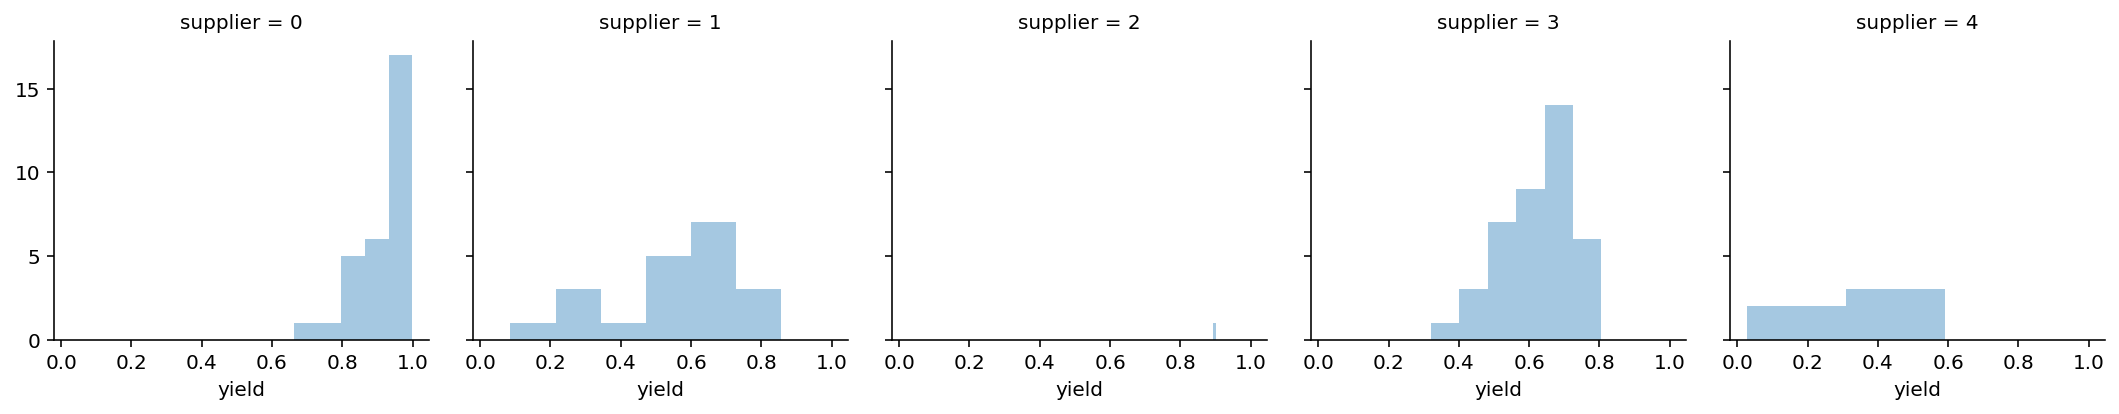

In [38]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

So this is the data we have available to try and estimate the true yield of every supplier.

## The dynamics of operating a warehouse

In order to assess how much plastic we need we first need to know how much processed plastic we can sell. If we buy too few we are leaving money on the table, if we buy too many we will have to put them in storage which costs money (`HOLDING_COST`). Let's assume we can sell a plastic unit for `$5000` and it costs us `$1000` in holding cost.

In [39]:
SALES_PRICE = 5000 
HOLDING_COST = 1000

In [40]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

Above, let's define our loss function which takes as inputs how many units of plastic we have in stock, how much processed plastic customers want, at what price we bought the plastic, at what price we can sell the processed plastic, and what the holding costs are per unit of plastic:

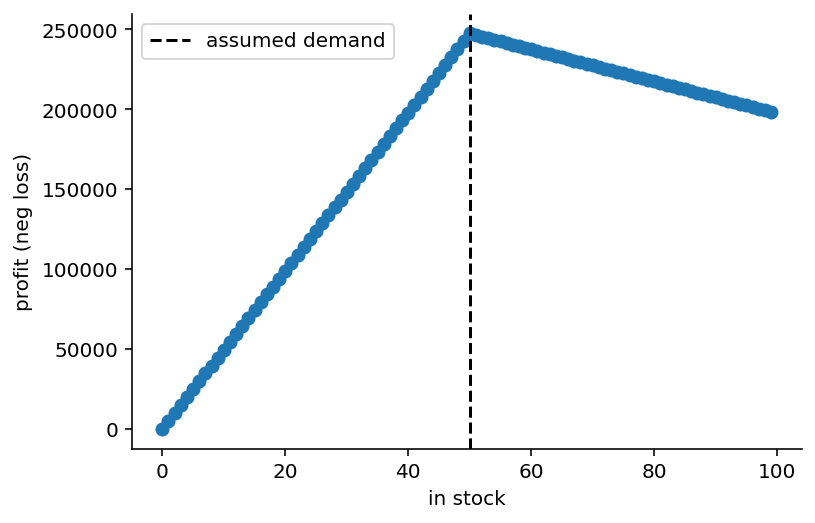

In [41]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50))
plt.axvline(50, c='k', ls='--', label='assumed demand')
plt.xlabel('in stock')
plt.ylabel('profit (neg loss)')
sns.despine()
plt.legend()
plt.show()

As you can see, if customer demand is 50 units of processed plastic, we maximize our profit if we have 50 units of processed in stock. Having fewer processed plastic units eats into our profits at a greater rate than ordering excess plastic because in this setup our margins are larger than the holding cost.

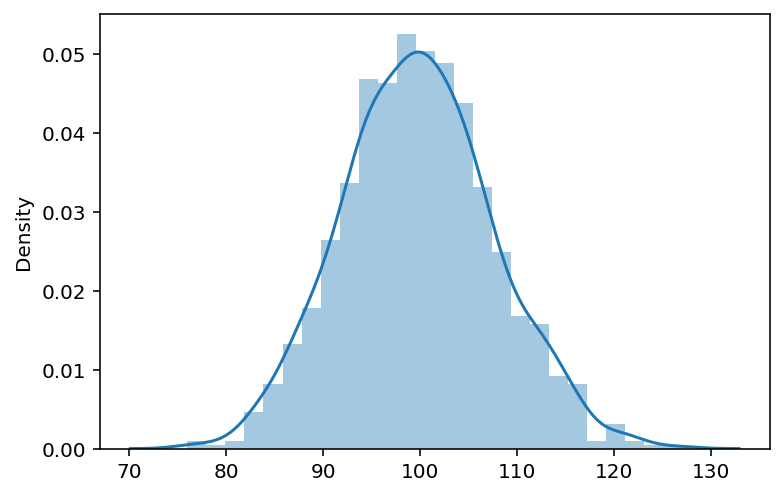

In [42]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

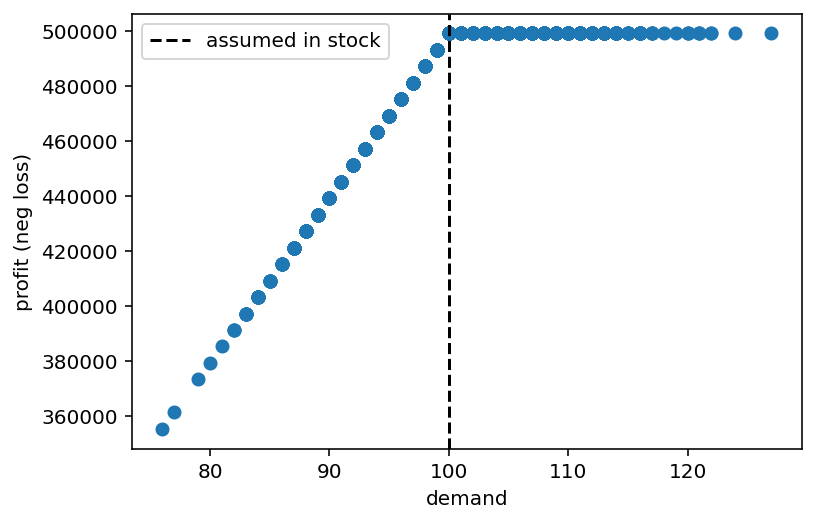

In [43]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand')
plt.ylabel('profit (neg loss)')
plt.axvline(100, c='k', ls='--', label='assumed in stock')
plt.legend()
plt.show()

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer plastic units but also have to pay holding costs), but as demand exceeds the number of plastic units we have in stock our profit stays flat because we can't sell more than what we have.

Let's model the supplier. And help my friend an operations manager make better decisions. 

In [44]:
%%time
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=5)
    β = pm.HalfNormal('β', sd=10., shape=5)
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
                alpha=α[i], beta=β[i],
                observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:12<00:00, 156.94draws/s]


CPU times: user 7.84 s, sys: 464 ms, total: 8.3 s
Wall time: 32.6 s


/Users/user/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


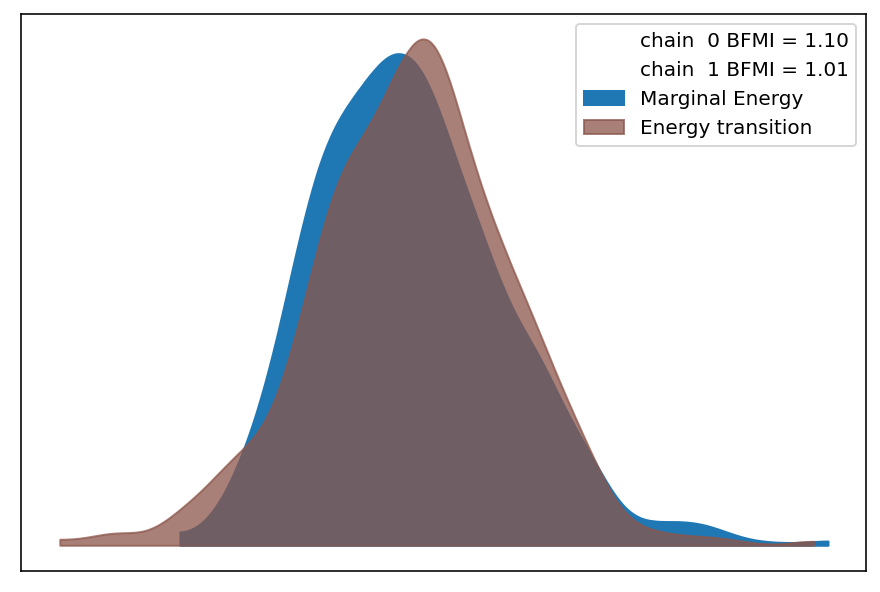

In [45]:
# make sure convergence looks good
az.plot_energy(trace);

## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) of our model which generates new data based on our estimated posteriors.

In [46]:
%%time
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

100%|██████████| 1000/1000 [00:05<00:00, 195.80it/s]

CPU times: user 4.63 s, sys: 104 ms, total: 4.73 s
Wall time: 5.11 s


/Users/user/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


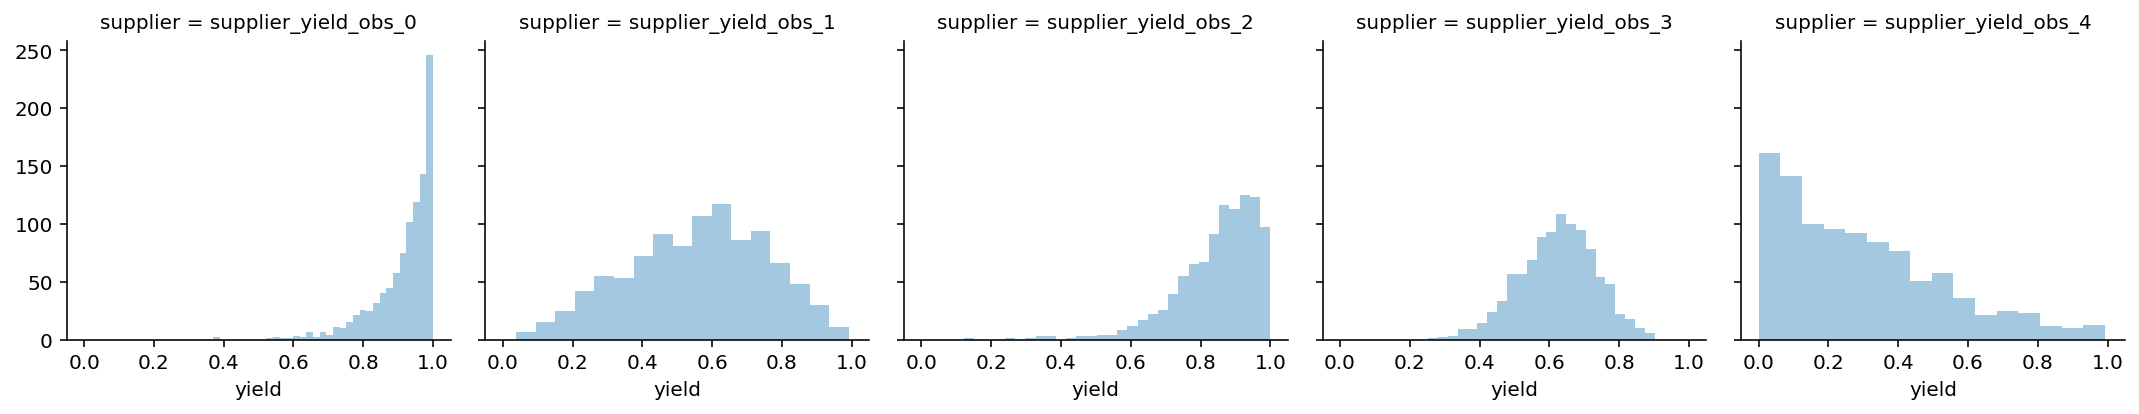

In [47]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

# Bayesian decision making
Let's create an objective function. 

Let's calculate the yield and price with what we have. And then we'll create an objective function. 

In [48]:
def calc_yield_and_price(orders, 
                         supplier_yield=PLASTIC_SUPPLIER_YIELD,
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price(PRICES)

(5720.0, 2060.4651162790697)

So given these (randomly picked) order amounts to each supplier and some deterministic yield, we would receive 572 functioning units of plastic at an effective price of 206 dollars each.

Now we have to actually do the optimization. First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution. (Same as other supply chain case)

In [49]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

Let's optimize

In [50]:
from scipy import optimize

In [78]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [20., 20., 40., 50., 20.]

In [79]:
bounds

[(0, 100), (0, 80), (0, 100), (0, 60), (0, 490)]

In [80]:
%%time
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)),
                              starting_value, 
                              bounds=bounds)

CPU times: user 1min 46s, sys: 636 ms, total: 1min 47s
Wall time: 1min 49s


In [81]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

Optimal order amount from every supplier = [ 0. 55. 93.  0.  8.]


In [82]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

Total order amount from all suppliers = 156.0


Great, we did it! Excitedly you go to your manager and tell her the amazing model you built and the optimal order amounts. Unfortunately, she is not impressed and asks "that's some fancy technique, but I'm not convinced this is actually better than what we currently use which is to just take the means of the yield distribution for each supplier."

## Evaluation

Slightly discouraged you go back to your desk and wonder why life is so unfair and you actually have to prove that things work and why "but it's Bayesian!" is not as convincing an argument as you hoped for. After some deep reflection you come to the conclusion that your manager might have a point and that additional complexity must be warranted and demonstrably better. To build a more compelling case, you decide to compare the naive method of just using the means to your fancy method in terms of expected profit in a simulation study.

Instead of samples from the posterior predictive, we can just pass a single sample -- the mean -- into our objective function.

In [83]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T
supplier_yield_mean

,0,1,2,3,4
0,0.918735,0.558903,0.896244,0.622691,0.320847


In [84]:
%%time
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100]), 
                                  starting_value, 
                                  bounds=bounds)

CPU times: user 288 ms, sys: 5.15 ms, total: 294 ms
Wall time: 302 ms


In [85]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))

Optimal order amount from every supplier = [  0.  69.   0.   0. 193.]


In [86]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Total order amount from all suppliers = 261.0


In [87]:
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(PLASTIC_SUPPLIER_YIELD, PLASTIC_SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2,Supplier 3,Supplier 4
0,0.880298,0.752686,0.997934,0.658027,0.451443
1,0.698046,0.307304,0.971085,0.530412,0.486905
2,0.676807,0.534287,0.891209,0.689580,0.327866
3,0.943773,0.666368,0.975907,0.800500,0.011289
4,0.911538,0.457898,0.556483,0.594632,0.698504


/Users/user/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


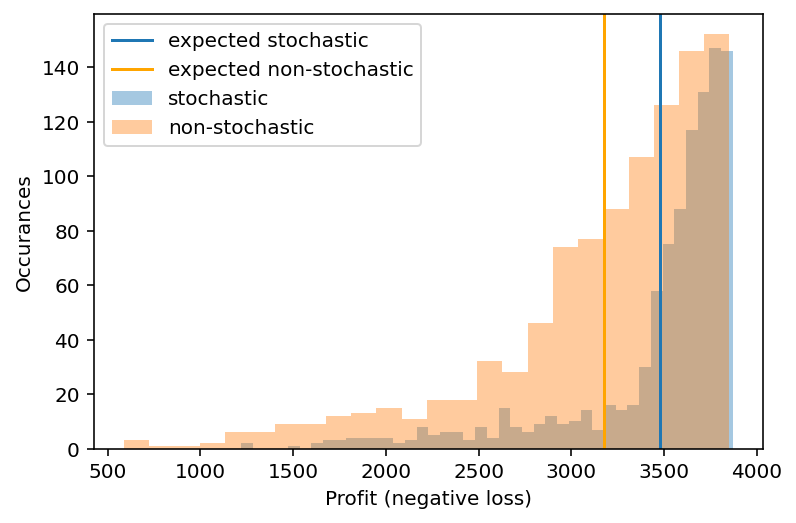

In [88]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend()
plt.xlabel('Profit (negative loss)')
plt.ylabel('Occurances')
plt.show()

In [89]:
print('Expected profit of Bayesian model = %.2f Dollars' % np.mean(neg_loss_stoch))

Expected profit of Bayesian model = 3475.87 Dollars


In [90]:
print('Expected profit of naive model = %.2f Dollars' % np.mean(neg_loss_non_stoch))

Expected profit of naive model = 3177.26 Dollars


So we successfully built a model and it's better than the naive model (our baseline) and this allows us to exploit more profit on the market. 

In [92]:
round(np.mean(neg_loss_stoch) - np.mean(neg_loss_non_stoch),2)

298.61

That's nearly 300 dollars profit on this example. At scale we could have even more profit. 